In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle
!mkdir /kaggle/data
with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"davidishimwe125","key":"8724ae834129df6e88a49a60d4b511a1"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json
!chmod 600 /kaggle/data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73248 sha256=e2a1e175ba3783761cb37034eee6325465d762a3024b90d42050cbdf19c4a9fb
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.12
    Uninstalling kaggle-1.6.12:
      Successfully uninstalled kaggle-1.6.12


In [2]:
# commands to download data from kaggle
!kaggle competitions download -c home-credit-credit-risk-model-stability
#!kaggle competitions download -c 11-785-f22-hw1p2
!mkdir '/kaggle/data'

100%|█████████████████████████████████████▉| 3.14G/3.14G [01:21<00:00, 33.9MB/s]
100%|██████████████████████████████████████| 3.14G/3.14G [01:21<00:00, 41.6MB/s]
mkdir: cannot create directory '/kaggle/data': File exists


In [3]:
!unzip -qo '/kaggle/working/home-credit-credit-risk-model-stability.zip' -d '/kaggle/data'

In [4]:
dataPath = "/kaggle/data/"

In [5]:
import numpy as np
import polars as pl
import pandas as pd

In [6]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [7]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    for column_name in df.columns:
        if column_name[-1] in ['A', 'P']:
            df = df.with_columns(pl.col(column_name).cast(pl.Float64).alias(column_name))
    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for column_name in df.columns:
        if df[column_name].dtype == 'object' or df[column_name].dtype == 'string':
            df[column_name] = df[column_name].astype('category')
            existing_categories = list(df[column_name].cat.categories)
            extended_categories = existing_categories + ['Unknown']
            df[column_name] = df[column_name].cat.set_categories(extended_categories, ordered=True)
    return df

#Read and set dtypes
##train
def read_and_set_dtypes(file_path: str) -> pl.DataFrame:
    return pl.read_csv(file_path).pipe(set_table_dtypes)
train_basetable = read_and_set_dtypes(dataPath + "csv_files/train/train_base.csv")

train_static = pl.concat(
    [
        read_and_set_dtypes(dataPath + "csv_files/train/train_static_0_0.csv"),
        read_and_set_dtypes(dataPath + "csv_files/train/train_static_0_1.csv"),
    ],
    how="vertical_relaxed",
)
train_static_cb = read_and_set_dtypes(dataPath + "csv_files/train/train_static_cb_0.csv")
train_person_1 = read_and_set_dtypes(dataPath + "csv_files/train/train_person_1.csv")
train_credit_bureau_b_2 = read_and_set_dtypes(dataPath + "csv_files/train/train_credit_bureau_b_2.csv")

## test
# Base table for test data
test_basetable = read_and_set_dtypes(dataPath + "csv_files/test/test_base.csv")

# Static tables for test data, combined with vertical relaxation to handle schema discrepancies
test_static = pl.concat(
    [
        read_and_set_dtypes(dataPath + "csv_files/test/test_static_0_0.csv"),
        read_and_set_dtypes(dataPath + "csv_files/test/test_static_0_1.csv"),
        read_and_set_dtypes(dataPath + "csv_files/test/test_static_0_2.csv"),
    ],
    how="vertical_relaxed",
)

# Other test tables, each processed through the `read_and_set_dtypes` function
test_static_cb = read_and_set_dtypes(dataPath + "csv_files/test/test_static_cb_0.csv")
test_person_1 = read_and_set_dtypes(dataPath + "csv_files/test/test_person_1.csv")
test_credit_bureau_b_2 = read_and_set_dtypes(dataPath + "csv_files/test/test_credit_bureau_b_2.csv")

In [8]:
## train
# Aggregating features from the train_person_1 table
train_person_1_feats_1 = train_person_1.group_by("case_id").agg([
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
])

# Selecting specific rows based on num_group1 from the train_person_1 table and renaming columns
train_person_1_feats_2 = train_person_1.filter(pl.col("num_group1") == 0).select([
    "case_id",
    pl.col("housetype_905L").alias("person_housetype")
])

# Aggregating features from the train_credit_bureau_b_2 table
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg([
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
])

# Function to select columns ending with specific letters from a table
def select_columns_by_suffix(table, suffixes):
    return [col for col in table.columns if col[-1] in suffixes]

# Selecting 'A' and 'M' type columns from static tables
selected_static_cols = select_columns_by_suffix(train_static, ("A", "M"))
selected_static_cb_cols = select_columns_by_suffix(train_static_cb, ("A", "M"))

# Joining all the tables on 'case_id'
data = train_basetable.join(
    train_static.select(["case_id"] + selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"] + selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

### test
# Aggregating features for the test_person_1 table
test_person_1_feats_1 = test_person_1.group_by("case_id").agg([
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
])

# Selecting specific rows based on num_group1 from the test_person_1 table and renaming columns
test_person_1_feats_2 = test_person_1.filter(pl.col("num_group1") == 0).select([
    "case_id",
    pl.col("housetype_905L").alias("person_housetype")
])

# Aggregating features from the test_credit_bureau_b_2 table
test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg([
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
])

# Joining all the test tables on 'case_id'
data_submission = test_basetable.join(
    test_static.select(["case_id"] + selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"] + selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [9]:
# Splitting case IDs into training, validation, and test sets
case_ids = data["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_temp = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_temp, train_size=0.5, random_state=1)

# Selecting columns for prediction based on specific naming conventions
cols_pred = [col for col in data.columns if col[-1].isupper() and col[:-1].islower()]

# Function to convert data from Polars to Pandas, filter by case_ids, and apply data type conversion
def from_polars_to_pandas(case_ids: pl.DataFrame):
    filtered_data = data.filter(pl.col("case_id").is_in(case_ids))
    base = filtered_data[["case_id", "WEEK_NUM", "target"]].to_pandas()
    X = filtered_data[cols_pred].to_pandas()
    X = convert_strings(X)  # Convert string columns to categorical
    y = filtered_data["target"].to_pandas()
    return base, X, y

# Generating datasets for training, validation, and testing
base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)


In [10]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (915995, 48)
Valid: (305332, 48)
Test: (305332, 48)


In [13]:
# Create S datasets for training and validation
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

# # Define LightGBM parameters
# params = {
#     "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
#     "objective": "binary",  # Binary classification
#     "metric": "auc",  # Evaluation metric: Area Under the Curve (AUC) for ROC
#     "max_depth": 5,  # Maximum depth of trees
#     "num_leaves": 61,  # Number of leaves in full trees
#     "learning_rate": 0.05,  # Learning rate
#     "feature_fraction": 0.9,  # Fraction of features to be randomly selected for each tree
#     "bagging_fraction": 0.8,  # Fraction of data to be randomly sampled for each iteration
#     "bagging_freq": 5,  # Frequency for bagging
#     "n_estimators": 1000,  # Number of boosting iterations
#     "verbose": -1,  # Verbosity of the output (-1 means silent)
# }
# import numpy as np
# from sklearn.utils import class_weight

# # Assuming you have X (features) and y (target variable)
# class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
# class_weight_dict = dict(zip(np.unique(y), class_weights))

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,  # Increased max_depth for higher complexity
    "num_leaves": 51,  # Decreased num_leaves to reduce overfitting
    "learning_rate": 0.03,  # Smaller learning rate for better convergence
    "feature_fraction": 0.7,  # Decreased feature fraction for regularization
    "bagging_fraction": 0.6,  # Decreased bagging fraction for regularization
    "bagging_freq": 10,  # Increased bagging frequency for better randomization
    "n_estimators": 2000,  # Increased number of estimators for better convergence
    "verbose": 1,  # Verbose set to 1 for monitoring training progress
    #"class_weight": class_weight_dict,  # Incorporating class weights
    #"scale_pos_weight": len(y) / (2 * np.sum(y)),  # Alternative class weight method
    "is_unbalance": True  # Enabling LightGBM's built-in handling of imbalanced data
}
# Train the model with early stopping
gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_valid],  # Validation set for early stopping
    callbacks=[
        lgb.log_evaluation(50),  # Log every 50 iterations
        lgb.early_stopping(10)  # Stop training if one metric of one validation data doesn't improve in 10 iterations
    ]
)


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 28872, number of negative: 887123
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.348986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8980
[LightGBM] [Info] Number of data points in the train set: 915995, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031520 -> initscore=-3.425111
[LightGBM] [Info] Start training from score -3.425111
Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.737833
[100]	valid_0's auc: 0.744554
[150]	valid_0's auc: 0.748994
[200]	valid_0's auc: 0.75189
[250]	valid_0's auc: 0.753755
[300]	valid_0's auc: 0.754863
Early stopping, best iteration is:
[321]	valid_0's auc: 0.755247


In [20]:
# Function to predict and append scores to the base DataFrame
def append_scores(base_df, features_df, model):
    predictions = model.predict(features_df, num_iteration=model.best_iteration)
    base_df["score"] = predictions

# Appending scores to the base DataFrames
for base, X in [(base_train, X_train), (base_valid, X_valid), (base_test, X_test)]:
    append_scores(base, X, gbm)

# Calculating and printing AUC scores for the train, validation, and test sets
auc_train = roc_auc_score(base_train["target"], base_train["score"])
auc_valid = roc_auc_score(base_valid["target"], base_valid["score"])
auc_test = roc_auc_score(base_test["target"], base_test["score"])

print(f'The AUC score on the train set is: {auc_train:.4f}')
print(f'The AUC score on the valid set is: {auc_valid:.4f}')
print(f'The AUC score on the test set is: {auc_test:.4f}')

The AUC score on the train set is: 0.7930
The AUC score on the valid set is: 0.7552
The AUC score on the test set is: 0.7528


In [21]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    # Group by 'WEEK_NUM' and calculate Gini coefficient for each group
    grouped = base.sort_values("WEEK_NUM").groupby("WEEK_NUM")
    gini_in_time = [
        2 * roc_auc_score(group["target"], group["score"]) - 1
        for _, group in grouped
    ]

    # Linear fit to the Gini coefficients over time
    x = np.arange(len(gini_in_time))
    y = np.array(gini_in_time)
    a, b = np.polyfit(x, y, 1)

    # Calculate residuals from the linear fit and their standard deviation
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)

    # Average Gini coefficient
    avg_gini = np.mean(gini_in_time)

    # Stability score calculation
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

# Calculating stability scores for train, validation, and test sets
stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)
stability_score_test = gini_stability(base_test)

# Printing stability scores
print(f'The stability score on the train set is: {stability_score_train:.4f}')
print(f'The stability score on the valid set is: {stability_score_valid:.4f}')
print(f'The stability score on the test set is: {stability_score_test:.4f}')


The stability score on the train set is: 0.5625
The stability score on the valid set is: 0.4814
The stability score on the test set is: 0.4652


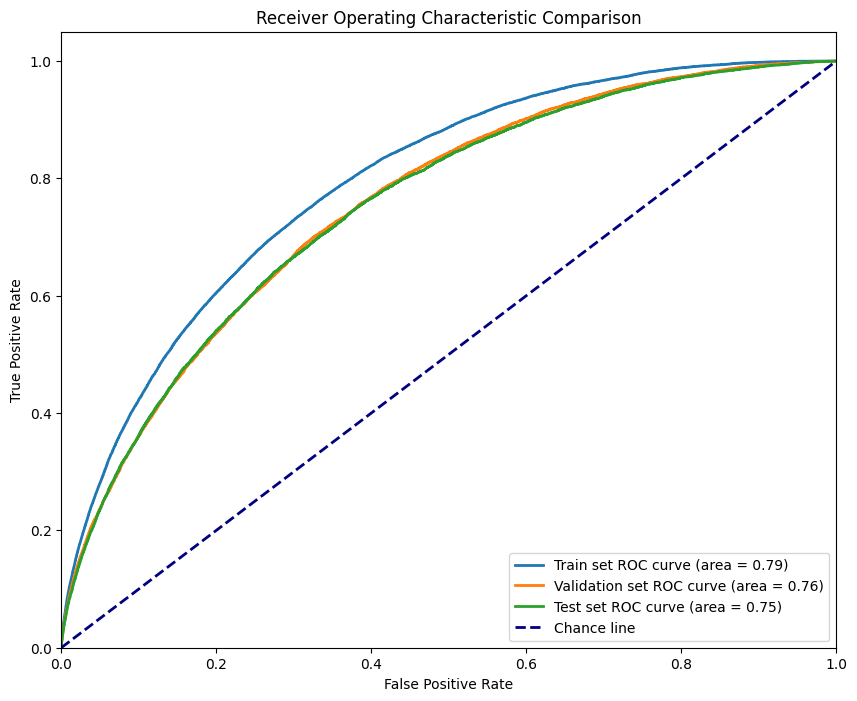

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curves on the same graph for comparison
def plot_combined_roc_curves(base_dfs, set_names):
    plt.figure(figsize=(10, 8))
    lw = 2  # Line width

    for base_df, set_name in zip(base_dfs, set_names):
        fpr, tpr, _ = roc_curve(base_df["target"], base_df["score"])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, label=f'{set_name} set ROC curve (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Chance line')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Comparison')
    plt.legend(loc="lower right")
    plt.show()

# Plotting combined ROC curve
plot_combined_roc_curves([base_train, base_valid, base_test], ["Train", "Validation", "Test"])
